In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Elementary DQN Analysis

In [3]:

MODEL_PATH = '../model_checkpoints/untrained_model.keras'
model = keras.models.load_model(MODEL_PATH)

I0000 00:00:1766352935.619538     488 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3333 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [40]:
# Get DQN summary (layer names, shapes, etc.)
model.summary()

Model: "DualBranchDQN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ state_input         │ (None, 60, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reward_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │      2,560 │ state_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ reward_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60, 32)    │      6,176 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 60, 32)    │      3,104 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ state_output        │ (None, 64)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reward_output       │ (None, 4)         │         68 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ late_fusion         │ (None, 68)        │          0 │ state_output[0][… │
│ (Concatenate)       │                   │            │ reward_output[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,416 │ late_fusion[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ advantage_value     │ (None, 3)         │         51 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Mean)         │ (None, 1)         │          0 │ advantage_value[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ state_value (Dense) │ (None, 1)         │         17 │ dense_4[0][0]   

 Total params: 60,554 (236.54 KB)

 Trainable params: 20,184 (78.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,370 (157.70 KB)

In [23]:
weights = model.layers[2].get_weights()

In [27]:
np.shape(weights[0])

(3, 13, 64)

In [29]:
mean = []
for i in range(0, 64):
    print('Channel ', i)
    print(weights[0][:, :, i])
    print(np.mean(weights[0][:, :, i]))
    mean.append(np.mean(weights[0][:, :, i]))

Channel  0
[[-0.43365923  0.6730974   0.26463342  1.0241898   0.48751834  0.40648207
   0.38037848  0.8691312   0.95635164 -1.2507048   0.01014385  1.4054017
  -2.1761298 ]
 [-1.3424938   0.50008506  0.29136893  0.07814742  0.53578776 -0.06032645
   0.27282777  0.801946    0.8825366  -1.1496316  -0.19017278  1.1884124
  -2.0541668 ]
 [-0.8988379   0.42675146  0.4642404  -0.24571453  0.7273186  -0.38961467
   0.1251982   0.7323513   0.7511739  -1.2260269  -0.5996277   1.1329967
  -1.7094358 ]]
0.04261352
Channel  1
[[-2.8744528e-01  2.0209205e-01  1.3824168e-01 -4.4310465e-01
   2.4184035e-03  3.5908613e-01  7.4436218e-01  2.7182274e-02
  -4.2553410e-01 -4.3200585e-01  2.1231432e-01 -7.1683848e-01
   9.0086979e-01]
 [-1.3493004e-01  1.4260419e-01  4.9235042e-02  2.6601303e-01
   3.1440669e-01  4.3229422e-01  8.0625123e-01  7.5677253e-02
  -6.0331738e-01 -1.6614040e-02  4.5111695e-01 -6.5565544e-01
   7.9153341e-01]
 [-5.6475419e-01  3.7874645e-01 -4.8192971e-05  2.5043559e-01
   9.03102

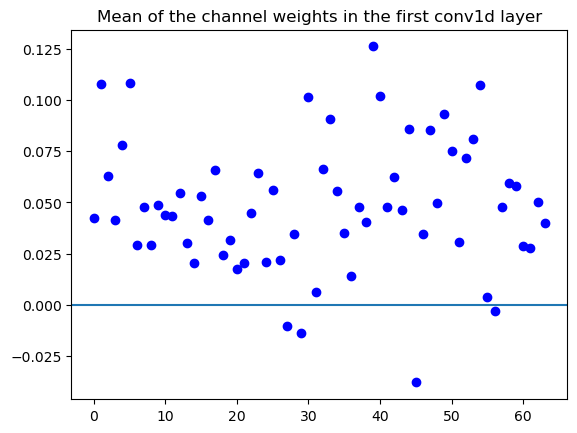

In [36]:
plt.plot(mean, 'bo')
plt.axhline(y=0)
plt.title('Mean of the channel weights in the first conv1d layer')
plt.show()

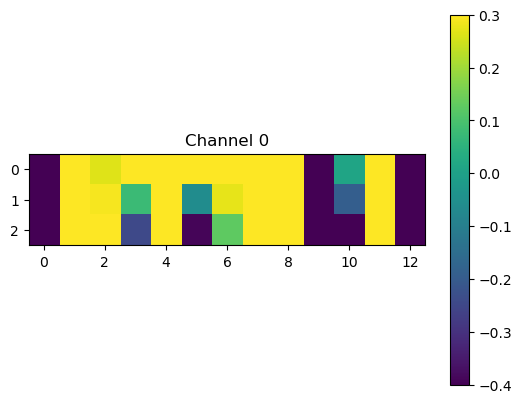

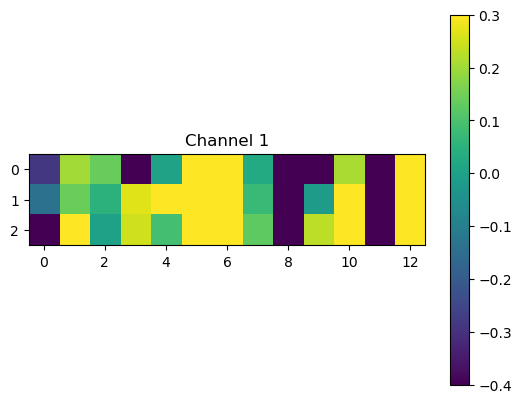

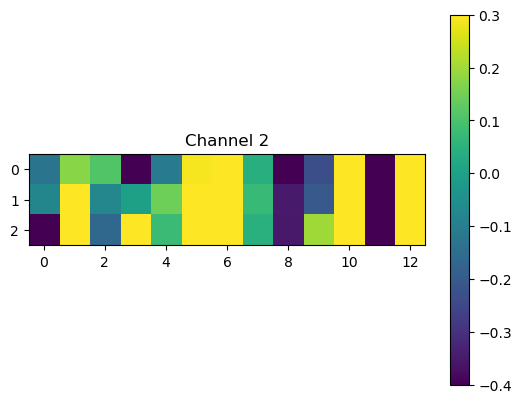

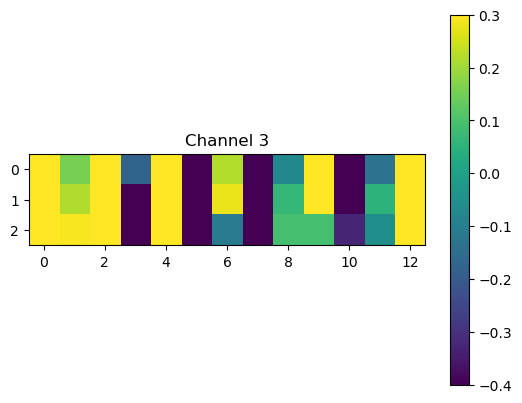

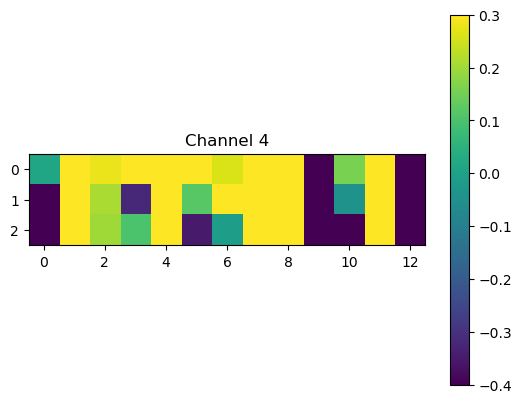

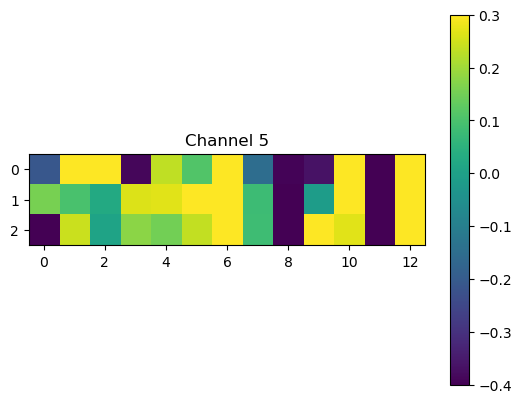

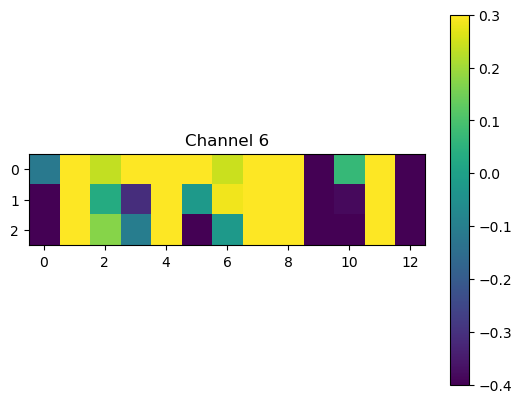

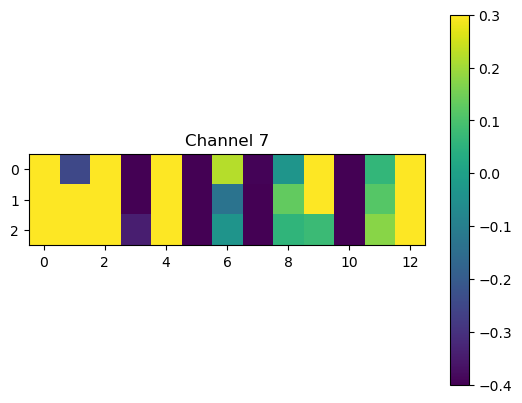

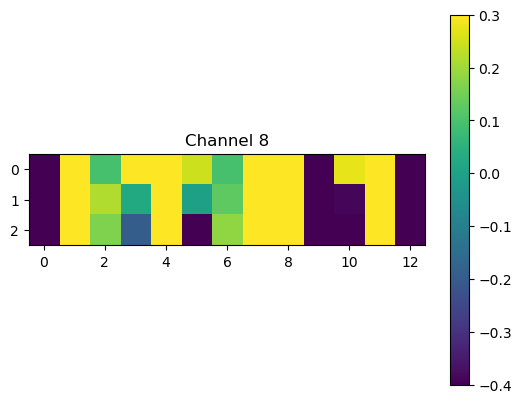

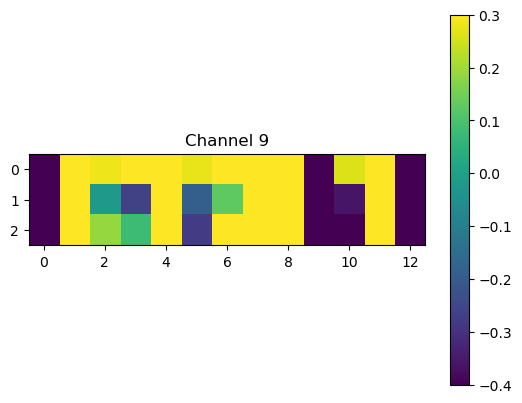

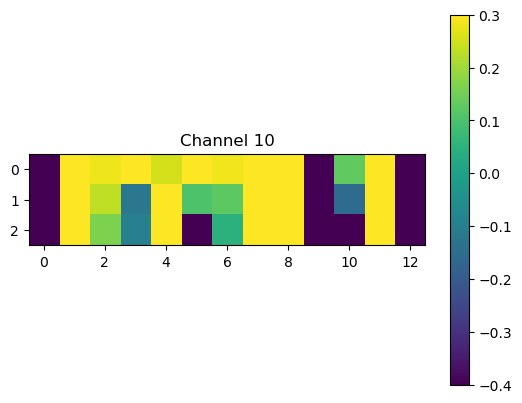

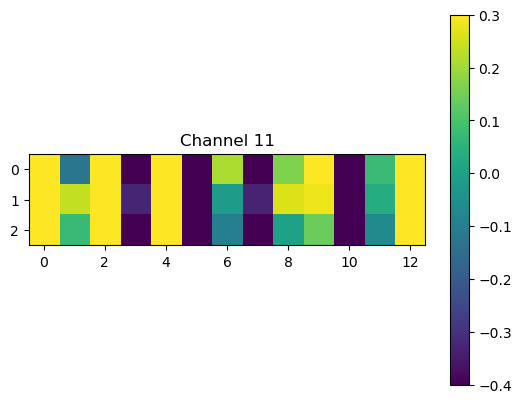

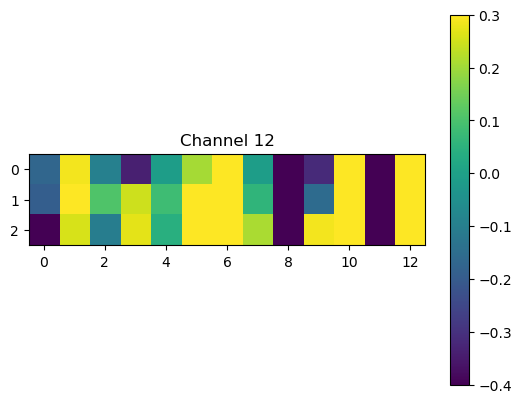

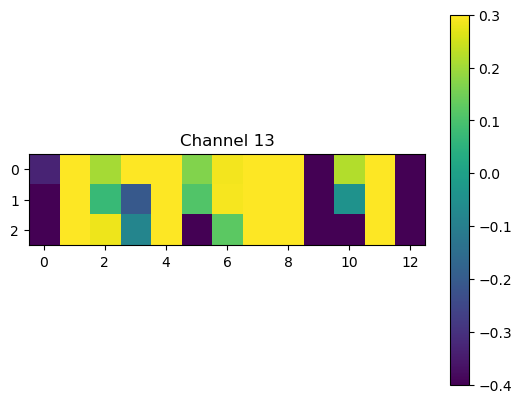

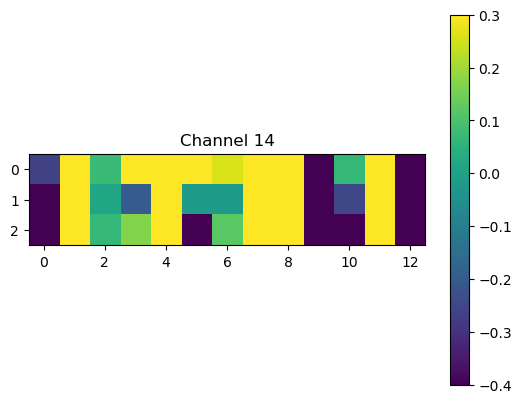

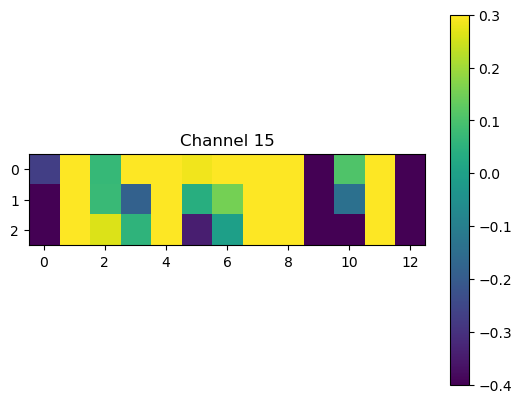

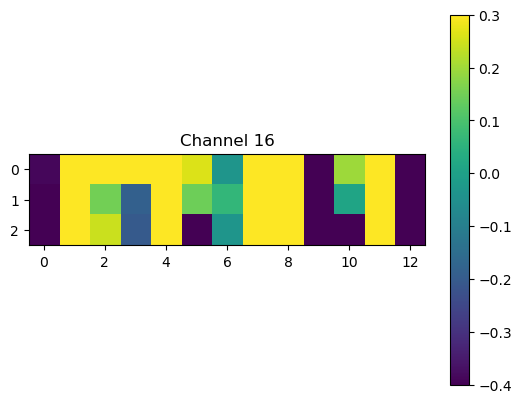

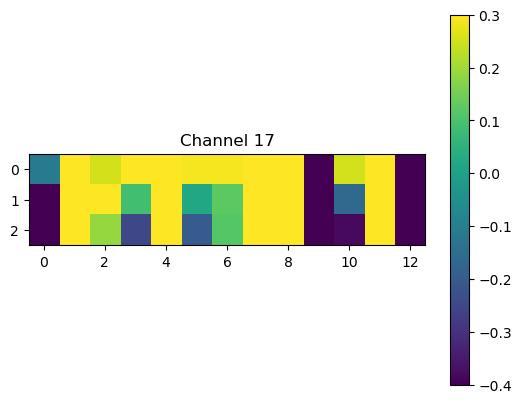

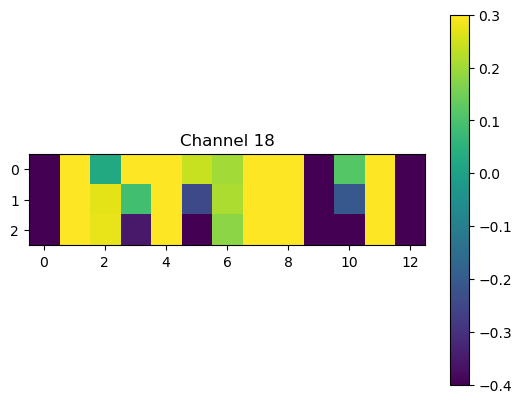

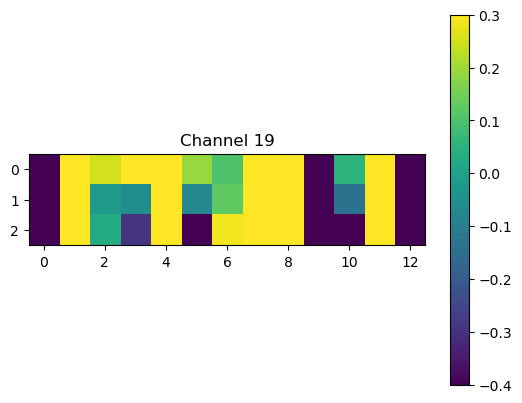

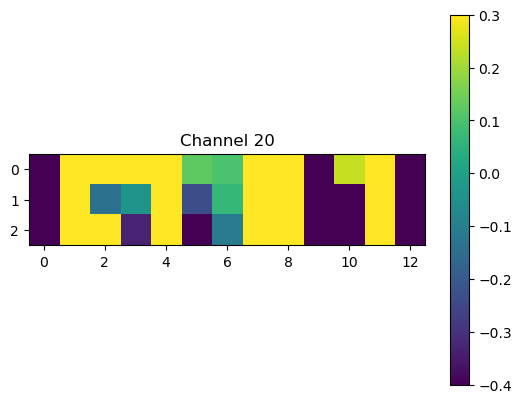

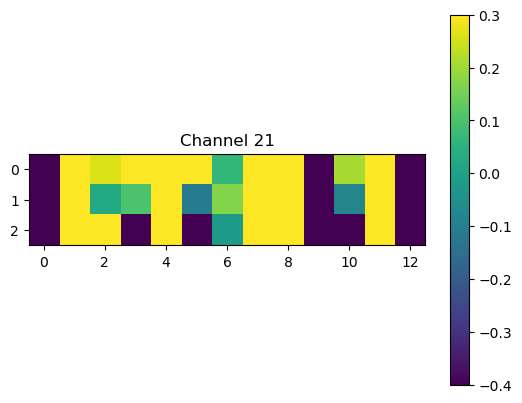

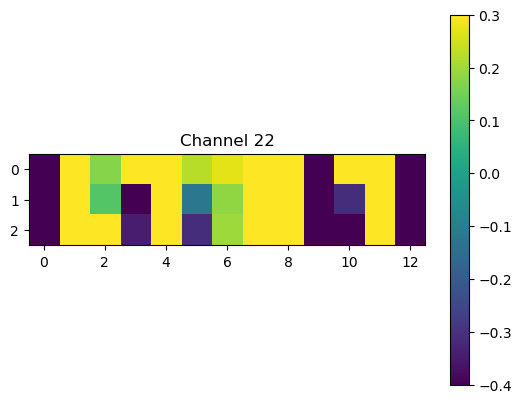

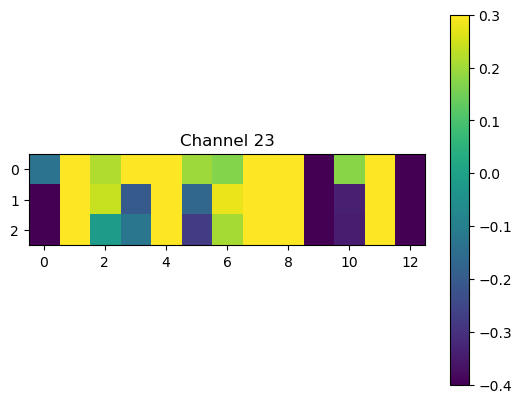

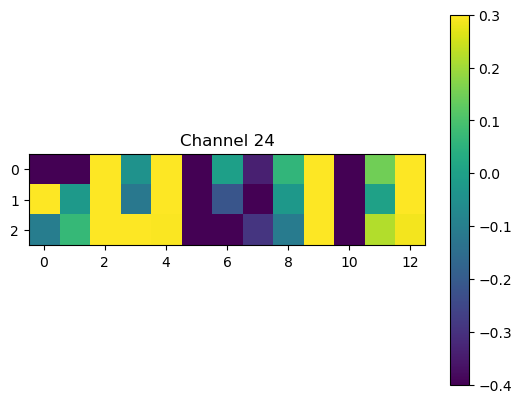

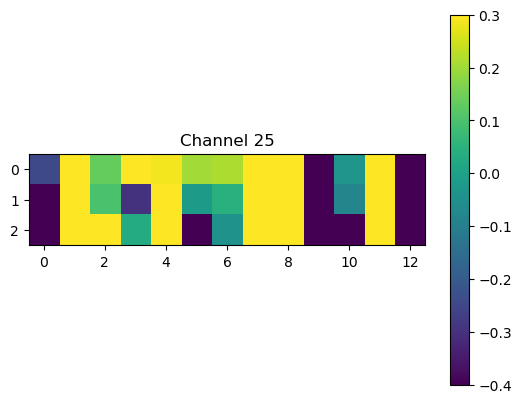

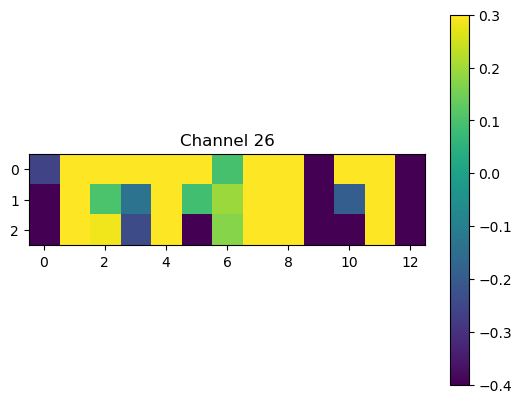

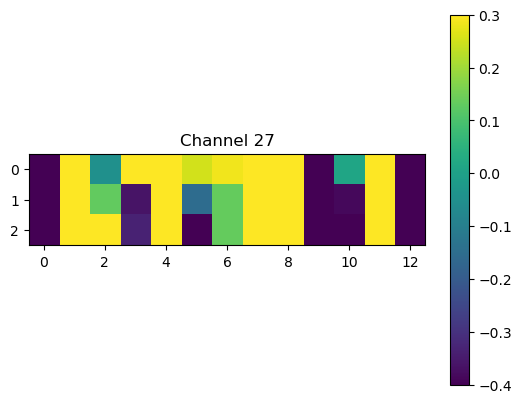

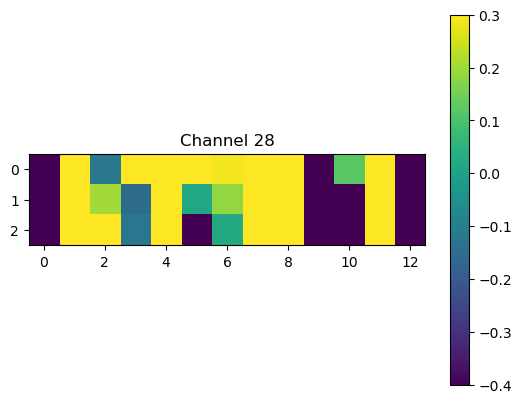

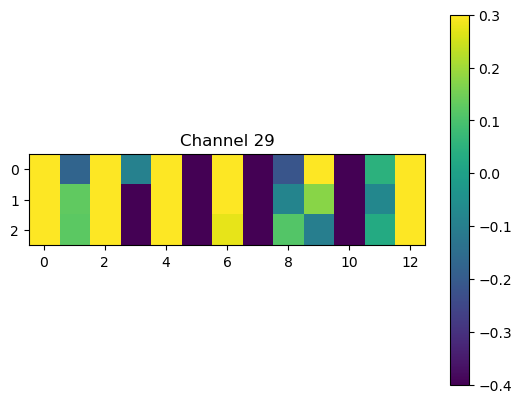

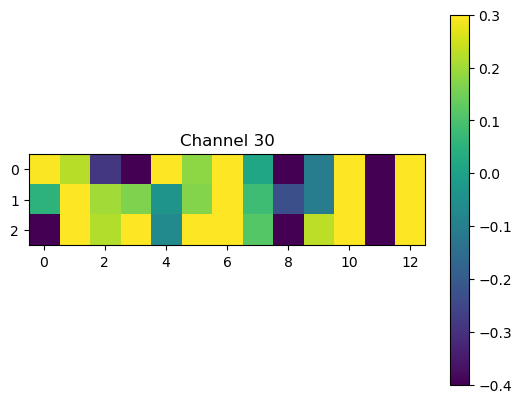

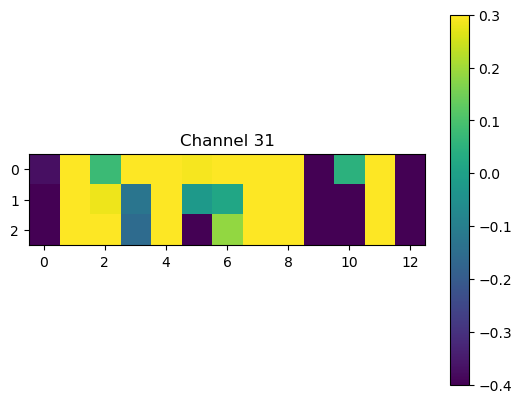

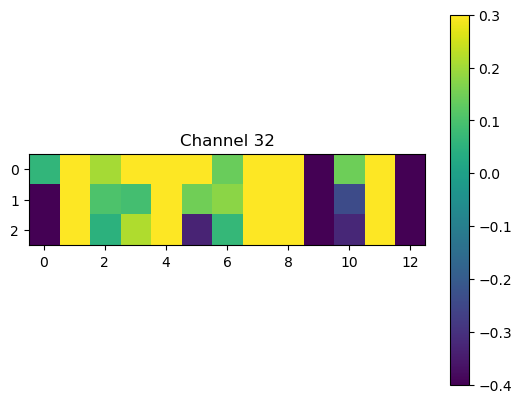

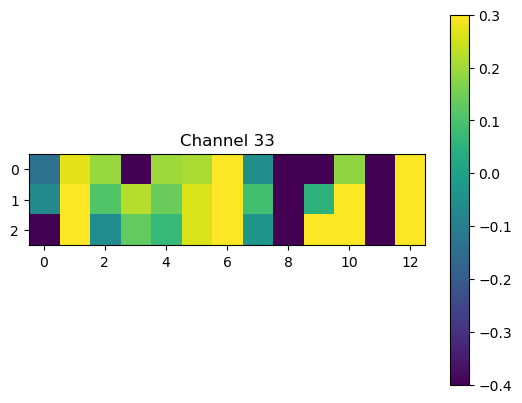

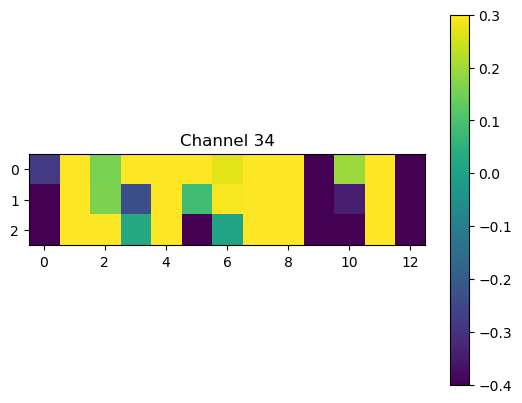

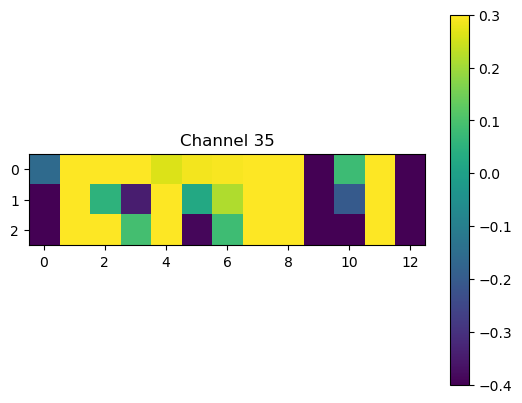

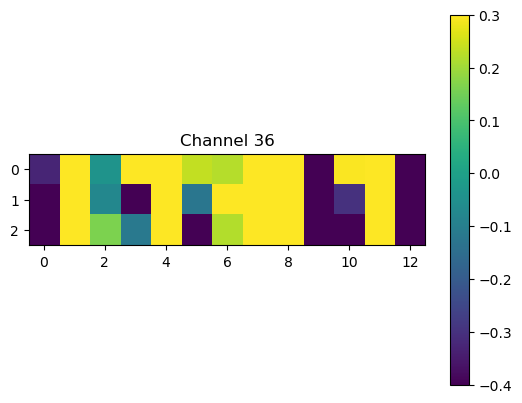

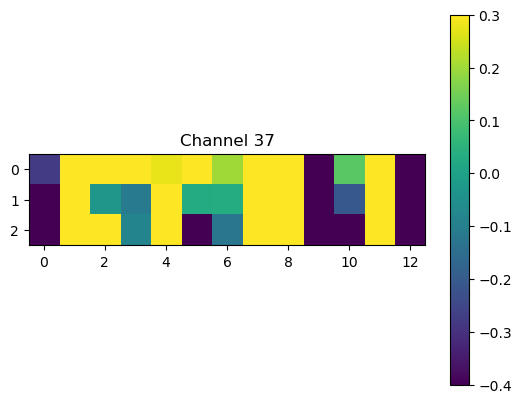

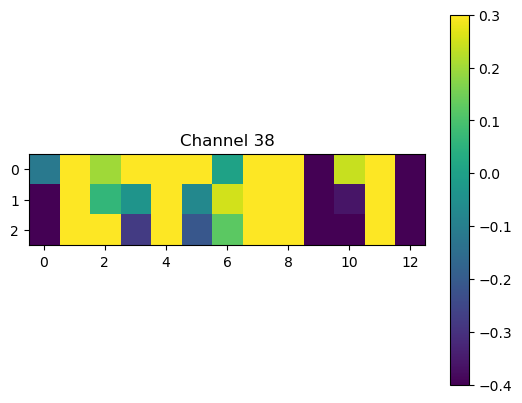

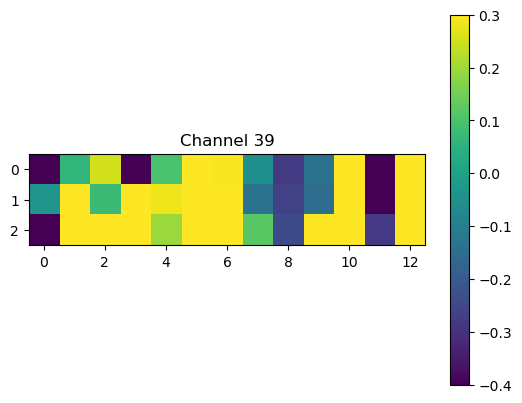

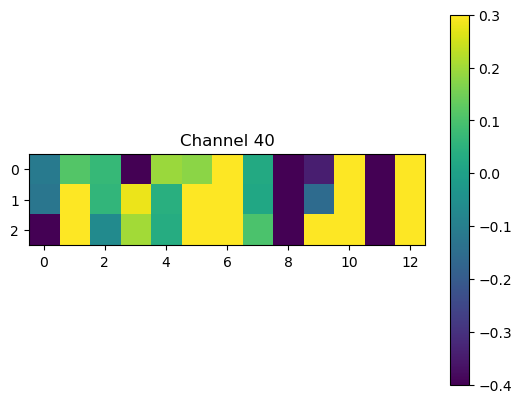

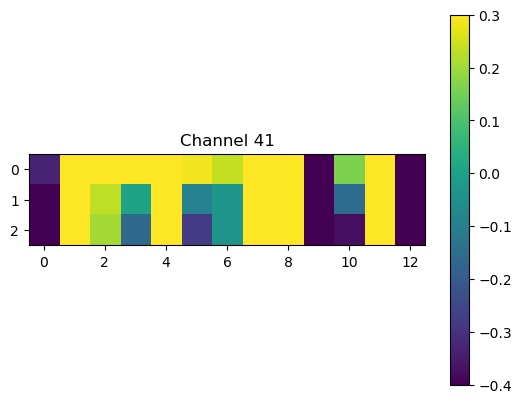

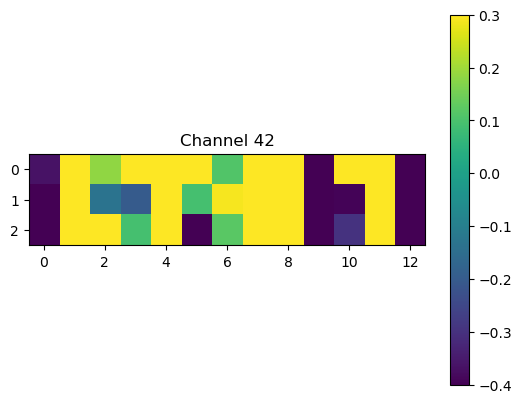

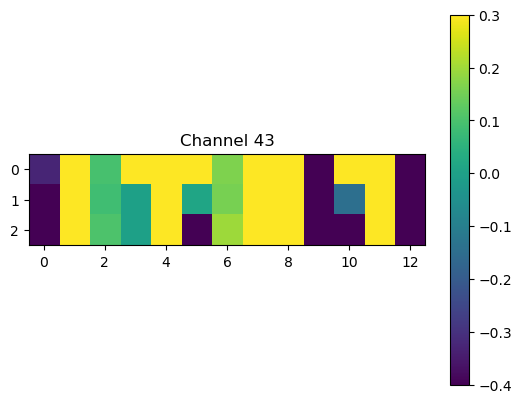

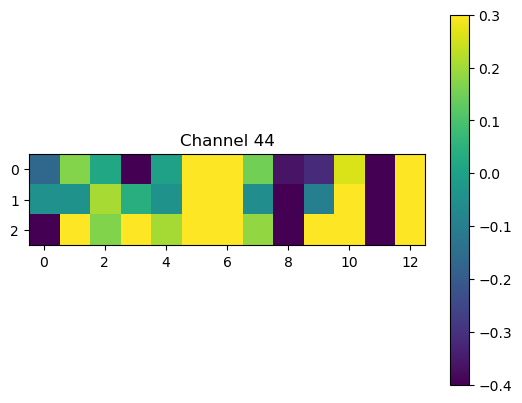

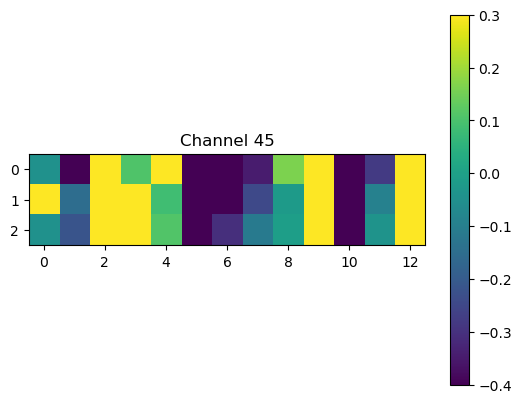

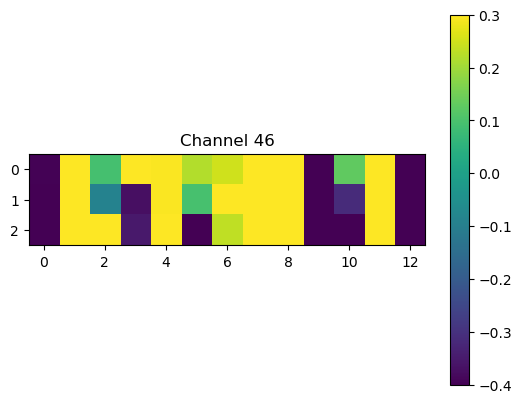

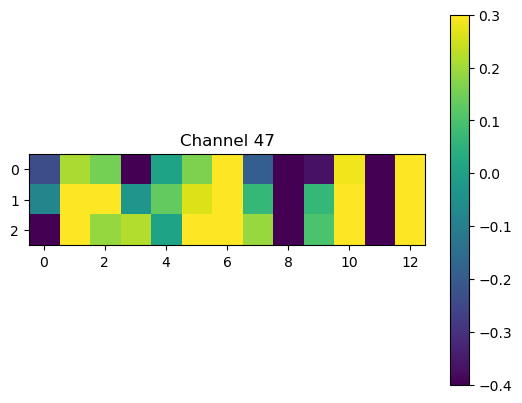

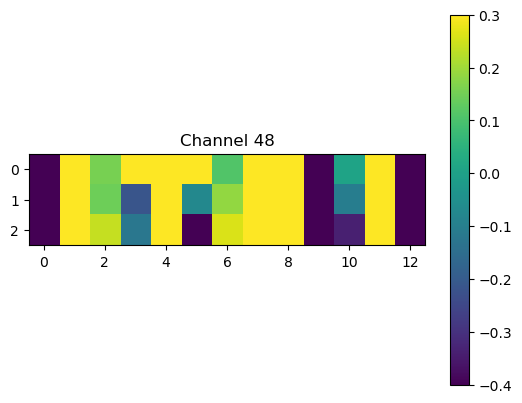

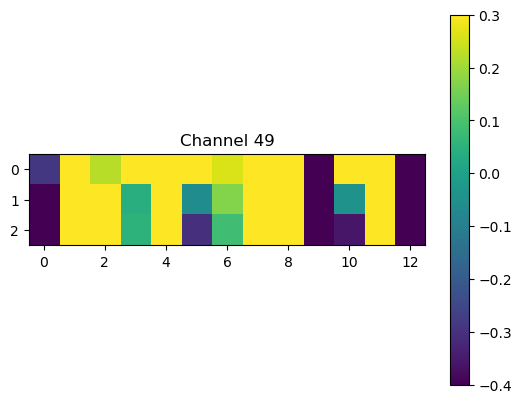

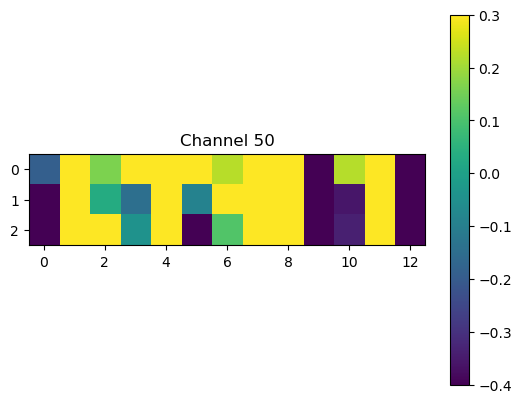

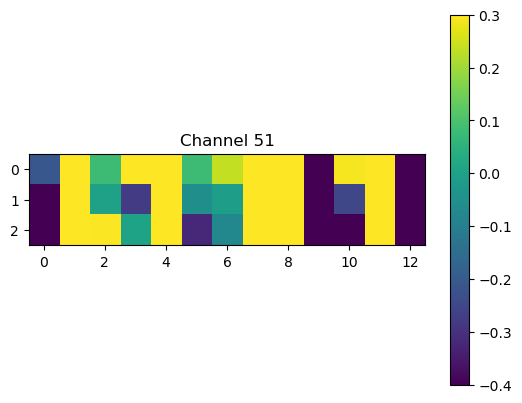

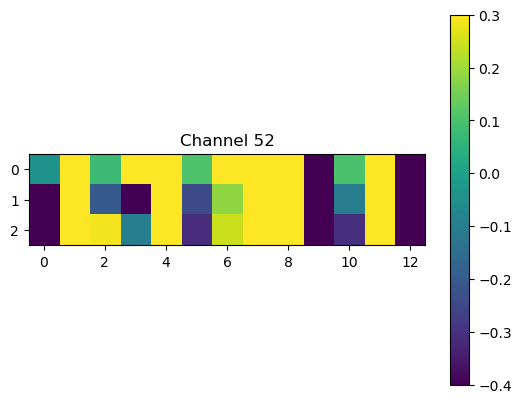

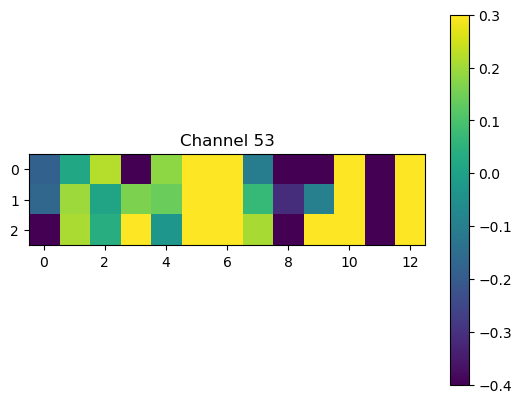

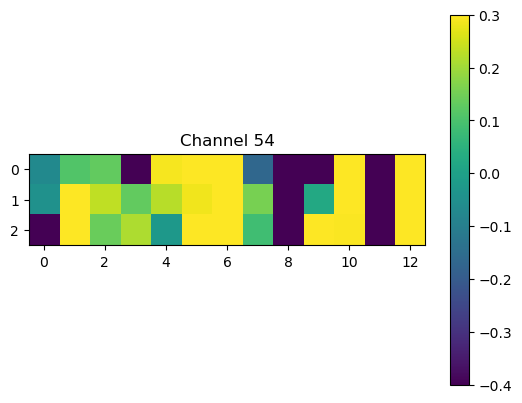

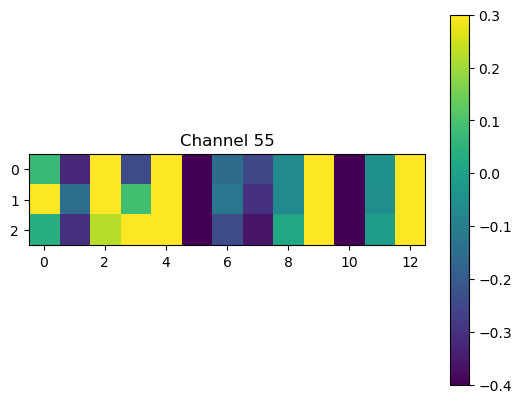

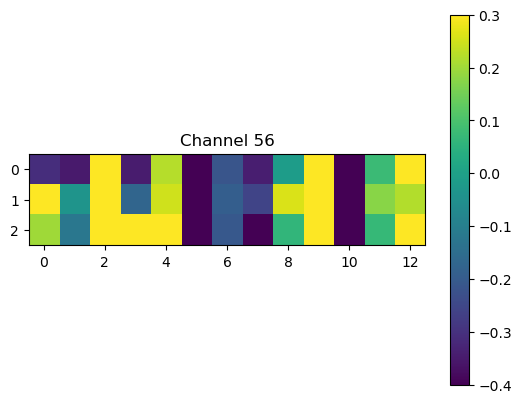

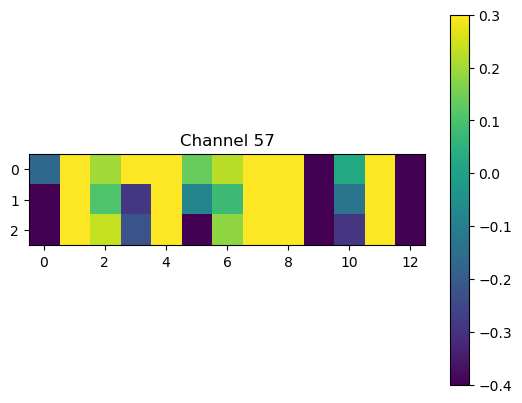

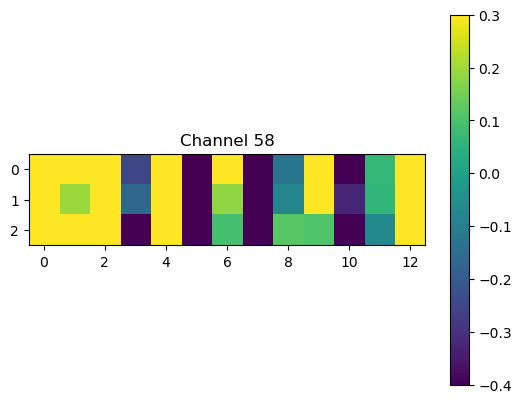

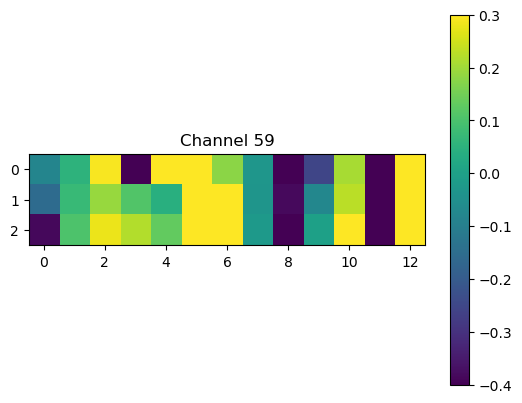

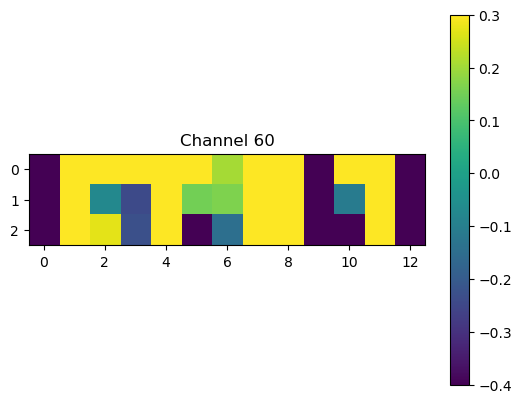

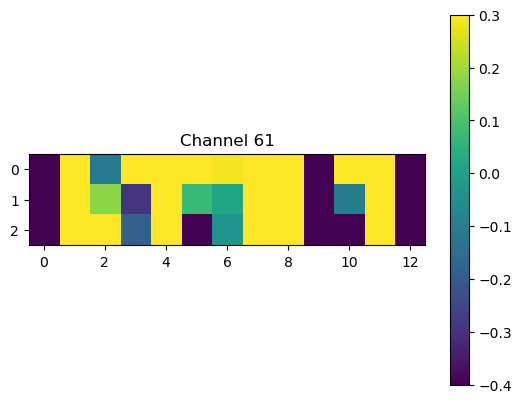

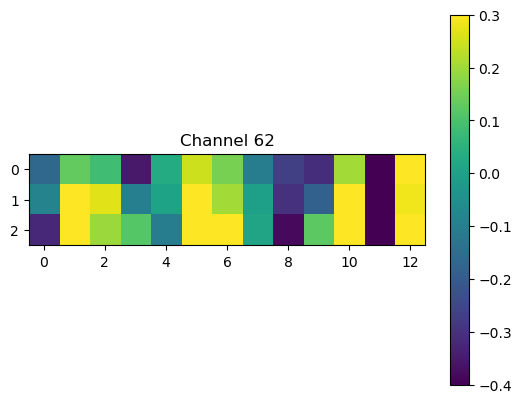

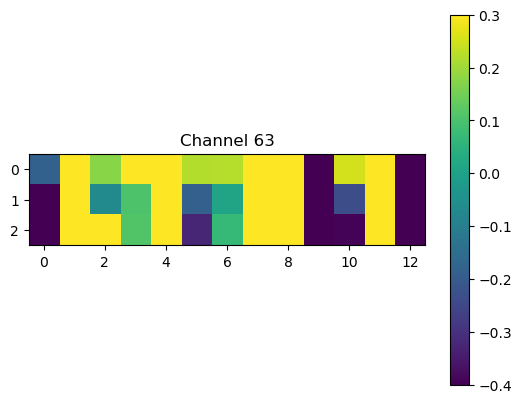

In [37]:
for i in range(0, 64):
    plt.imshow(weights[0][:, :, i], vmin=-0.4, vmax=0.3)
    plt.title('Channel {}'.format(i))
    plt.colorbar()
    plt.show()